![Cardio Image](https://img.freepik.com/free-photo/human-heart-design_1048-1855.jpg?size=626&ext=jpg&ga=GA1.1.110088987.1677679311&semt=ais)
<h1>Cardio Catch Diseases </h1>

## 0.0 - Planning and Business Knowledge

<h4>0.1. Business Problem.</h4>
<p>Cardio Catch Diseases is a company specialized in detecting heart disease in the early stages. Its business model lies in offering an early diagnosis of cardiovascular disease for a certain price.

<h4>0.2. Objective</h4>
    <li>Growth diagnostic precision and make stable.</li>


<h4>0.3. Justification</h4>
    <li>Currently, it's a manual diagnostic by humans.</li>
    <li>Low Precision, between 55% and 65%.</li>
    <li>Hight cost around one thousand (1.000,00) Reals with operators and machines costing.</li>
    <li>The revenue is variable accordingly precision from diagnostics, 500 each 5% above than 50% precision.</li>
    
<h4>0.4. Solution Proposal</h4>
    <lu>
        <li>Collect data from <a href="https://www.kaggle.com/sulianova/cardiovascular-disease-dataset">Kaggle</a></li>
        <li>Build a binary classification with <b>Machine Learning</b> or <b>statistics models</b> solution to diseases prediction.</li>
    </lu>
    
<h4>0.5 Report</h4>
    <lu>
        <li>What the precision accuracy from the solution?.</li>
        <li>How much profit you will get because of that solution?</li>
        <li>how reliable is the solution?</li>
    </lu>

<h4>0.6 Premises</h4>
    <lu>
        <li>Drop inconsistent data from low pressure .</li>
        <li>Drop inconsistent data from high pressure</li>
        <li>Drop inconsistent data from height</li>
        <li>Drop inconsistent data from weight</li>
    </lu>

## 1.0 - Imports

### 1.1 - Libraries

In [36]:
import pandas as pd
import numpy as np
# #import inflection 
# import datetime
# from random import sample as sp
from   pandas_profiling      import ProfileReport #conda install -c conda-forge ydata-profiling


# # Database CRUD
from sqlalchemy import create_engine
import sqlite3

# # Data Transformation
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# # visualization
import seaborn as sns
import matplotlib.pyplot as plt
# #from scipy.stats import pointbiserialr


# # Machine Learning, selection and split
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, recall_score, precision_score
# import pickle
# #from boruta import BorutaPy
# from sklearn.linear_model import LogisticRegression 
# from xgboost import XGBClassifier
# from sklearn.neighbors import KNeighborsClassifier
# #from lightgbm import LGBMClassifier
# from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


# #Configurations
from IPython.display import Image
from IPython.display import HTML
import warnings

### 1.2 - Funcions

In [37]:




# # Calculating Scores to classification 
# def metrics_score(y_valid, y_hat, mdl_name:str, transform_before_split:bool, obs:str):
#     '''
#         y_hat:    is the prediction array
#         y_valid:  is the true targe array or series
#         mdl_name: is the name of machine learning model
#         transform_before_split: If True it was transformation before of Split else False 
#         obs:      is to any observation that you want to write
        
#         positive_true  = (y_hat[y_hat == y_valid] == 1).sum()
#         positive_false = (y_hat[y_hat != y_valid] == 1).sum()
#         negative_false = (y_hat[y_hat != y_valid] == 0).sum()
        
#         Accuracy formula  -->   accuracy   = np.mean(y_hat == y_valid)
#         Precision formula -->   precision  = positive_true/(positive_true+positive_false)      
#         Recall formula    -->   recall     = positive_true/(positive_true+negative_false)
        
#         Return -->> mdl_name, accuracy, precision, recall, transform_before_split, datetime.date.today(), obs
        
#         See more: https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-
#         acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c
        
#         By: Diego Poleto Mayer
#         Email: diegopmayer@gmail.com
    
#     '''
#     accuracy = accuracy_score(y_valid, y_hat)
#     precision = precision_score(y_valid, y_hat)
#     recall = recall_score(y_valid, y_hat)
    
#     return pd.DataFrame([[mdl_name, accuracy, precision, recall, 
#                         transform_before_split, datetime.date.today(), obs]], 
#                         columns=['mdl_name', 'accuracy', 'precision', 'recall', 
#                                  'split_before_scaling', 'date', 'obs'])
    
#     #return mdl_name, accuracy, precision, recall, transform_before_split, datetime.date.today(), obs


# # Calculating phi to correlation between two dichotomous variables
# def phi_correlation(col1, col2):

# 	'''

#         The phi coefficient it's to correlation between dichotomous vs dichotomous. 
#         col1, col2 must be dichotomous variables.

#     '''

# 	table = pd.crosstab(col1, col2, margins=True)

# 	a = table.iloc[0, 0]
# 	b = table.iloc[0, 1]
# 	c = table.iloc[1, 0]
# 	d = table.iloc[1, 1]
# 	r_1 = table.iloc[0, 2]
# 	r_2 = table.iloc[1, 2]
# 	c_1 = table.iloc[2, 0]
# 	c_2 = table.iloc[2, 1]

# 	phi = round((a * d - b * c) / math.sqrt(r_1 * r_2 * c_1 * c_2), 2)

# 	return sns.heatmap(pd.DataFrame({col1.name:phi}, index=[col2.name]), annot=True)


# Jupyter configuring to better experience
def jupyter_settings():
    %matplotlib inline
    %pylab inline
        
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()  

# To hide warning messages
warnings.filterwarnings('ignore')


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 1.3 - Data Collect - CSV

In [38]:
# Loading dataset
df = pd.read_csv(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\datasets\cardio_train.csv', sep=';')

#Test split
df, df_test = train_test_split(df)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
5490,7806,15915,1,165,60.0,120,80,1,1,0,0,1,0
15043,21507,14456,1,167,73.0,120,80,1,1,0,0,0,1
4249,5997,14399,1,163,62.0,120,80,1,3,0,0,1,0
30507,43611,16876,1,170,75.0,110,60,1,1,0,0,1,1
23889,34149,19597,1,162,77.0,130,80,1,2,0,0,0,0


### 1.4 - Creating Datawerehouse

##### 1.4.1 - Rename Columns

In [39]:
# Old columns
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [40]:
# Rewriting columns names and replace then
new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
       'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']
df.columns = new_col
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'hight_pressure',
       'low_pressure', 'cholesterol', 'glucose', 'smoker', 'alcohol', 'active',
       'cardio'],
      dtype='object')

##### 1.4.2 - Database

In [41]:
# creating database
path_local="C:/Users/Utente77/repos/cardio_catch_disease_PA001/"
engine_db = create_engine(f"sqlite:////{path_local}/ccd.db", echo=False)
conn = sqlite3.Connection('cardio_disease.db')
cursor = conn.cursor()

# create table
query = '''CREATE TABLE IF NOT EXISTS patients(
                                id INTEGER,
                                age INTEGER,
                                gender INTEGER,
                                height INTEGER,
                                weight INTEGER,
                                hight_pressure INTEGER,
                                low_pressure INTEGER,
                                cholesterol INTEGER,
                                glucose INTEGER,
                                smoker INTEGER,
                                alcohol INTEGER,
                                active INTEGER,
                                cardio INTEGER
                                )'''

cursor.execute(query)
#engine = engine_db()
df.to_sql('patients', con=conn, if_exists='append', index=False)



52500

#### 1.4.3 - Data Collect from Database

In [42]:
# Selecting data
query="""
    SELECT *
    FROM patients;

"""
df=pd.read_sql_query(query,conn)


## 2.0 - Descriptive Analysis

### 2.1 - Dimensions

In [43]:
# Printing the data dimensions, how much rows and columns
print(f'{df.shape[0]} linhas.')
print(f'{df.shape[1]} colunas.')

105000 linhas.
13 colunas.


### 2.2 - Datatype and NaN fillout

In [44]:
# Columns Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              105000 non-null  int64  
 1   age             105000 non-null  int64  
 2   gender          105000 non-null  int64  
 3   height          105000 non-null  int64  
 4   weight          105000 non-null  float64
 5   hight_pressure  105000 non-null  int64  
 6   low_pressure    105000 non-null  int64  
 7   cholesterol     105000 non-null  int64  
 8   glucose         105000 non-null  int64  
 9   smoker          105000 non-null  int64  
 10  alcohol         105000 non-null  int64  
 11  active          105000 non-null  int64  
 12  cardio          105000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 10.4 MB


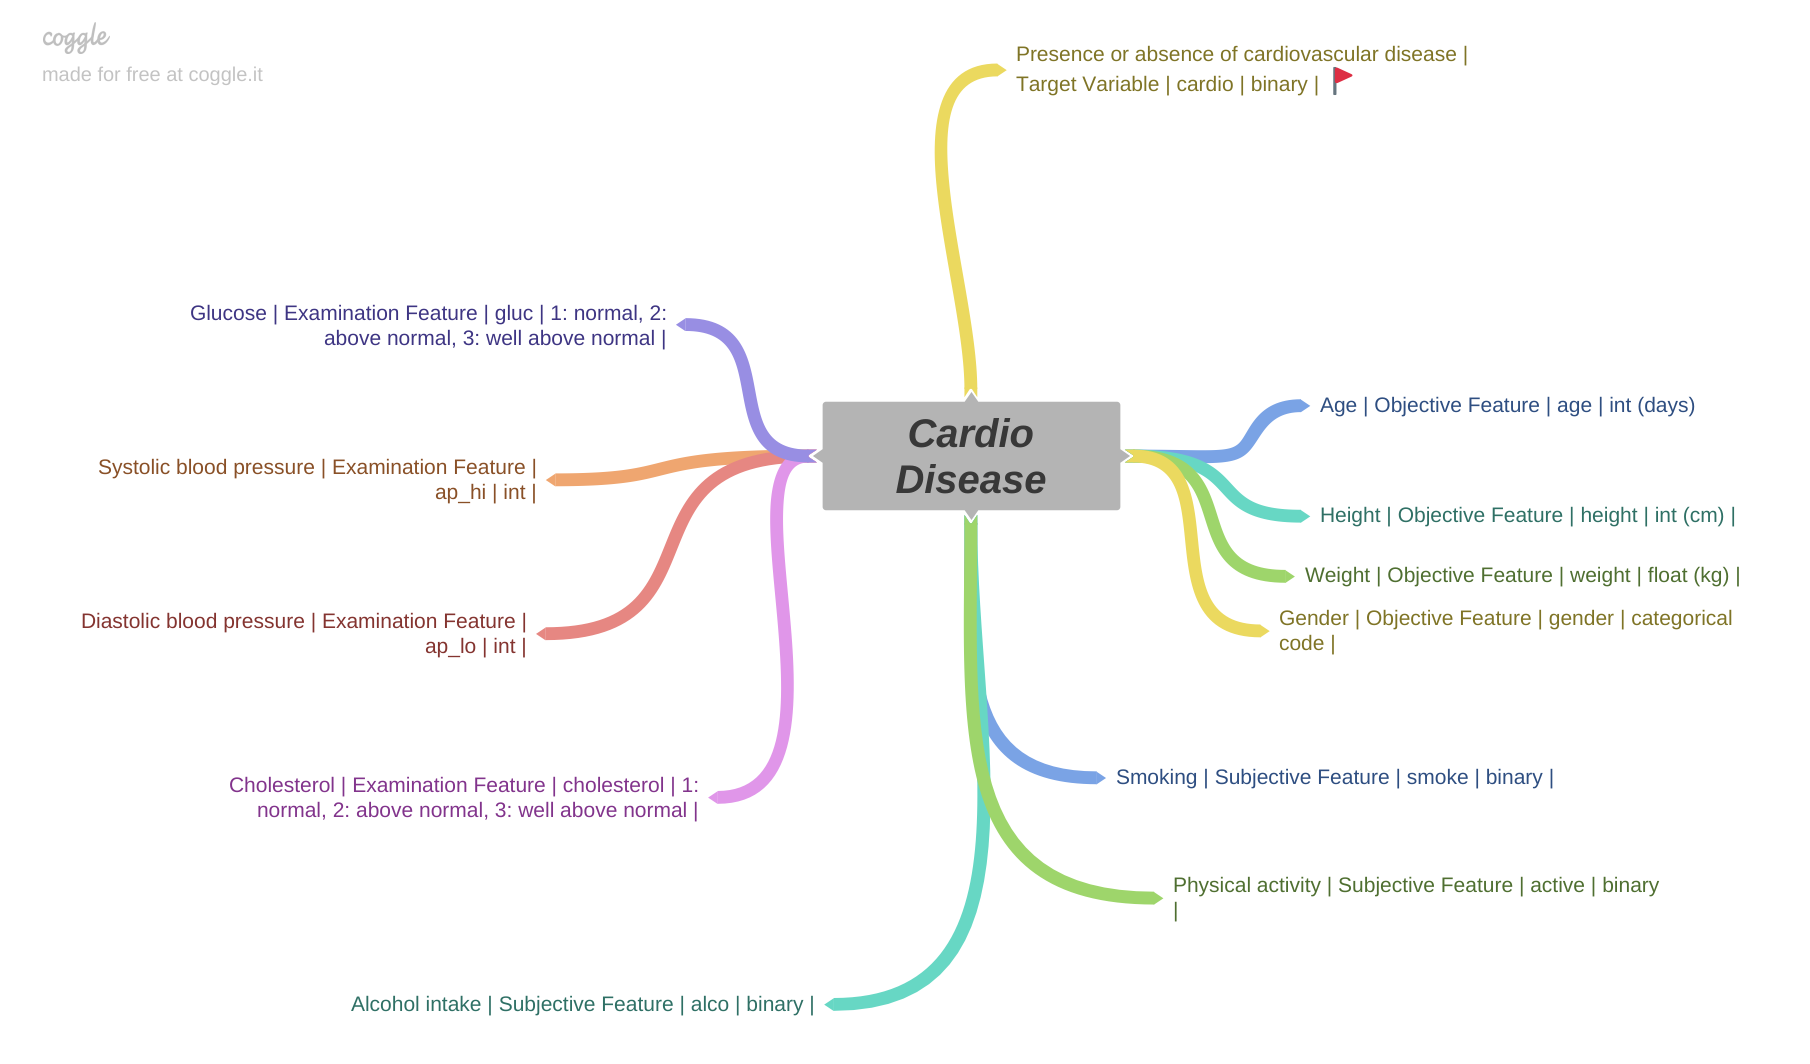

In [45]:
Image(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\img\Cardio_Disease.png')

In [46]:
# age - change days to year old
df['age'] = (df['age'] / 365).astype('int')

# height - change centimeters to meters
df['height'] = (df['height'] / 100)

aux=df.isna().sum().sort_values(ascending=False)
aux1=df.isna().sum().sort_values(ascending=False)/df.shape[0]*100

na=pd.concat([aux,aux1],axis=1)
na.columns=['NaN', 'NaN %']
na

,NaN,NaN %
id,0,0.0
age,0,0.0
gender,0,0.0
height,0,0.0
weight,0,0.0
hight_pressure,0,0.0
low_pressure,0,0.0
cholesterol,0,0.0
glucose,0,0.0
smoker,0,0.0


### 2.3 - Data Description

In [47]:
# profile=ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file(r"C:\Users\Utente77\repos\cardio_catch_disease_PA001\img\report.html")
# profile

In [48]:
num_attributes = df.select_dtypes( include=['int64', 'int32','float64'] )
cat_attributes = df.select_dtypes( exclude=['int64', 'int32','float64', 'datetime64[ns]'] )

In [49]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T.drop('id', axis=1)
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T.drop('id', axis=1)

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T.drop('id', axis=1) 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T.drop('id', axis=1) 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T.drop('id', axis=1) 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T.drop('id', axis=1) 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T.drop('id', axis=1) 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T.drop('id', axis=1) 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,29.00,64.0,35.00,52.837933,53.00,6.758313,-0.304874,-0.820478
1,gender,1.00,2.0,1.00,1.348933,1.00,0.476633,0.633900,-1.598201
2,height,0.55,2.5,1.95,1.643506,1.65,0.082208,-0.698520,8.551608
3,weight,10.00,200.0,190.00,74.194990,72.00,14.370111,1.009380,2.564292
4,hight_pressure,-150.00,16020.0,16170.00,128.553248,120.00,140.990303,96.687643,9786.076540
5,low_pressure,-70.00,11000.0,11070.00,96.319038,80.00,184.287133,32.753726,1507.904391
6,cholesterol,1.00,3.0,2.00,1.367152,1.00,0.681070,1.586686,0.988692
7,glucose,1.00,3.0,2.00,1.225390,1.00,0.571213,2.405903,4.335864
8,smoker,0.00,1.0,1.00,0.087876,0.00,0.283115,2.911397,6.476355
9,alcohol,0.00,1.0,1.00,0.053800,0.00,0.225623,3.955334,13.644927


#### 2.3.1  Inconsistent numbers of **hight pressure** and **low pressure** 


In [50]:

print(f'''{df[(df['low_pressure'] < 20) | (
    df['low_pressure'] > 150)].shape[0]} inconsistent rows on low_pressure.''')
print(f'''{df[(df['hight_pressure'] < 40) | (
    df['hight_pressure'] > 300)].shape[0]} inconsistent rows on hight_pressure. ''')

# filtering data without inconsistence data
df = df[(df['low_pressure'] >= 20) & (df['low_pressure'] <= 150)]
df = df[(df['hight_pressure'] >= 40) & (df['hight_pressure'] <= 300)]

1503 inconsistent rows on low_pressure.
336 inconsistent rows on hight_pressure. 


#### 2.3.2 Inconsistent numbers of **height**


In [51]:
print(f'''{df[df['height'] <= 1.45].shape[0]} inconsistent rows on height.''')

# Data filtering possible incosistent data by height 
df = df[df['height'] > 1.45]


772 inconsistent rows on height.


In [52]:
# Descriptive statistics after filters

describe = df.describe().T.drop('id', axis=0)
describe['range'] = describe['max'] - describe['min']
describe['kurtosis'] = describe.T.kurtosis()
describe['skew'] = describe.T.skew()
describe

,count,mean,std,min,25%,50%,75%,max,range,kurtosis,skew
age,102413.0,52.813442,6.758006,29.00,48.00,53.00,58.0,64.0,35.00,8.999993,3.162275
gender,102413.0,1.349917,0.476946,1.00,1.00,1.00,2.0,2.0,1.00,9.000000,3.162278
height,102413.0,1.645745,0.076697,1.46,1.59,1.65,1.7,2.5,1.04,9.000000,3.162278
weight,102413.0,74.175352,14.238119,11.00,65.00,72.00,82.0,200.0,189.00,8.999903,3.162252
hight_pressure,102413.0,126.622275,16.757475,60.00,120.00,120.00,140.0,240.0,180.00,8.999910,3.162250
low_pressure,102413.0,81.335123,9.601426,20.00,80.00,80.00,90.0,150.0,130.00,8.999956,3.162265
cholesterol,102413.0,1.364329,0.679388,1.00,1.00,1.00,1.0,3.0,2.00,9.000000,3.162278
glucose,102413.0,1.224971,0.570967,1.00,1.00,1.00,1.0,3.0,2.00,9.000000,3.162278
smoker,102413.0,0.088143,0.283504,0.00,0.00,0.00,0.0,1.0,1.00,9.000000,3.162278
alcohol,102413.0,0.053724,0.225473,0.00,0.00,0.00,0.0,1.0,1.00,9.000000,3.162278


## 3.0 - Feature Engineering

In [53]:
df1=df.copy(())

In [83]:
# A difference between systolic and diastolic arterial pressure, 

df1['difference'] = df1['hight_pressure'] - df1['low_pressure'] # A difference between systolic and diastolic arterial pressure
df1['convergent'] = df1['difference'].apply(lambda x: 1 if x <= 30 else 0) # lesser than 30mmhg called convergent 
df1['divergent'] = df1['difference'].apply(lambda x: 1 if x >= 60 else 0)# and upper than 60mmhg called divergent 

In [86]:
# BMI calculus and slices in four levels
df1['bmi'] = (df1['weight']/(df1['height'] * df1['height']))
df1['bmi_level'] = df1['bmi'].apply(lambda x: 
                                              '0' if x <= 18.5 else
                                              '1'      if x >  18.5 and x <= 24.9 else
                                              '2'  if x >= 25.0 and x <= 29.9 else
                                              '3')

In [56]:
# Hypertension and Hipotension binary
df1['hypertension'] = df1.apply(lambda x: 1 if x[4] >=140 and x[5] >= 90 else 0, axis=1)
df1['hypotension'] = df1.apply(lambda x: 1 if x[4] <=90 and x[5] <= 60 else 0, axis=1)

In [84]:
# Slicing ages with three ranges
df1['age_range'] = df1['age'].apply(lambda x: 1    if x <= 50 
                                                   else 2   if x >= 51 and x <= 59 
                                                   else 3 if x >= 60 
                                                   else x)

In [58]:
df1['weight_range'] = df1['weight'].apply(
    lambda x:   0.50 if x <= 50  else
                0.75 if x >= 51  and x <= 75 else
                1.00 if x >= 76  and x <= 100 else
                1.25 if x >= 101 and x <= 125 else
                1.50 if x >= 126 and x <= 150 else
                1.75 if x >= 151 and x <= 175 else 2.00)

## 4.0 - Data Filtering

In [87]:
df1.head()

,age,gender,height,weight,hight_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio,difference,convergent,divergent,bmi,bmi_level,hypertension,hypotension,age_range,weight_range
0,53,1,1.53,110.0,120,80,1,1,0,0,1,0,40,0,0,46.990474,3,0,0,2,1.25
1,47,1,1.58,58.0,140,90,1,1,0,0,1,1,50,0,0,23.233456,1,0,0,1,0.75
2,57,1,1.70,68.0,120,80,1,1,0,0,1,0,40,0,0,23.529412,1,0,0,2,0.75
3,55,1,1.65,68.0,120,80,1,1,0,0,0,0,40,0,0,24.977043,3,0,0,2,0.75
4,44,1,1.60,51.0,100,70,1,1,0,0,1,0,30,1,0,19.921875,1,0,0,1,0.75


In [60]:
# Data Filtering rows, values or columns
df1 = df1.drop('id', axis=1)

In [61]:
df1.shape

(102413, 21)

## 5.0 - EDA - Explolatory Data Analysis

In [64]:
df2=df1.copy()

### 5.1 - Hypothesis MindMap

### 5.2 - Univariate Analysis

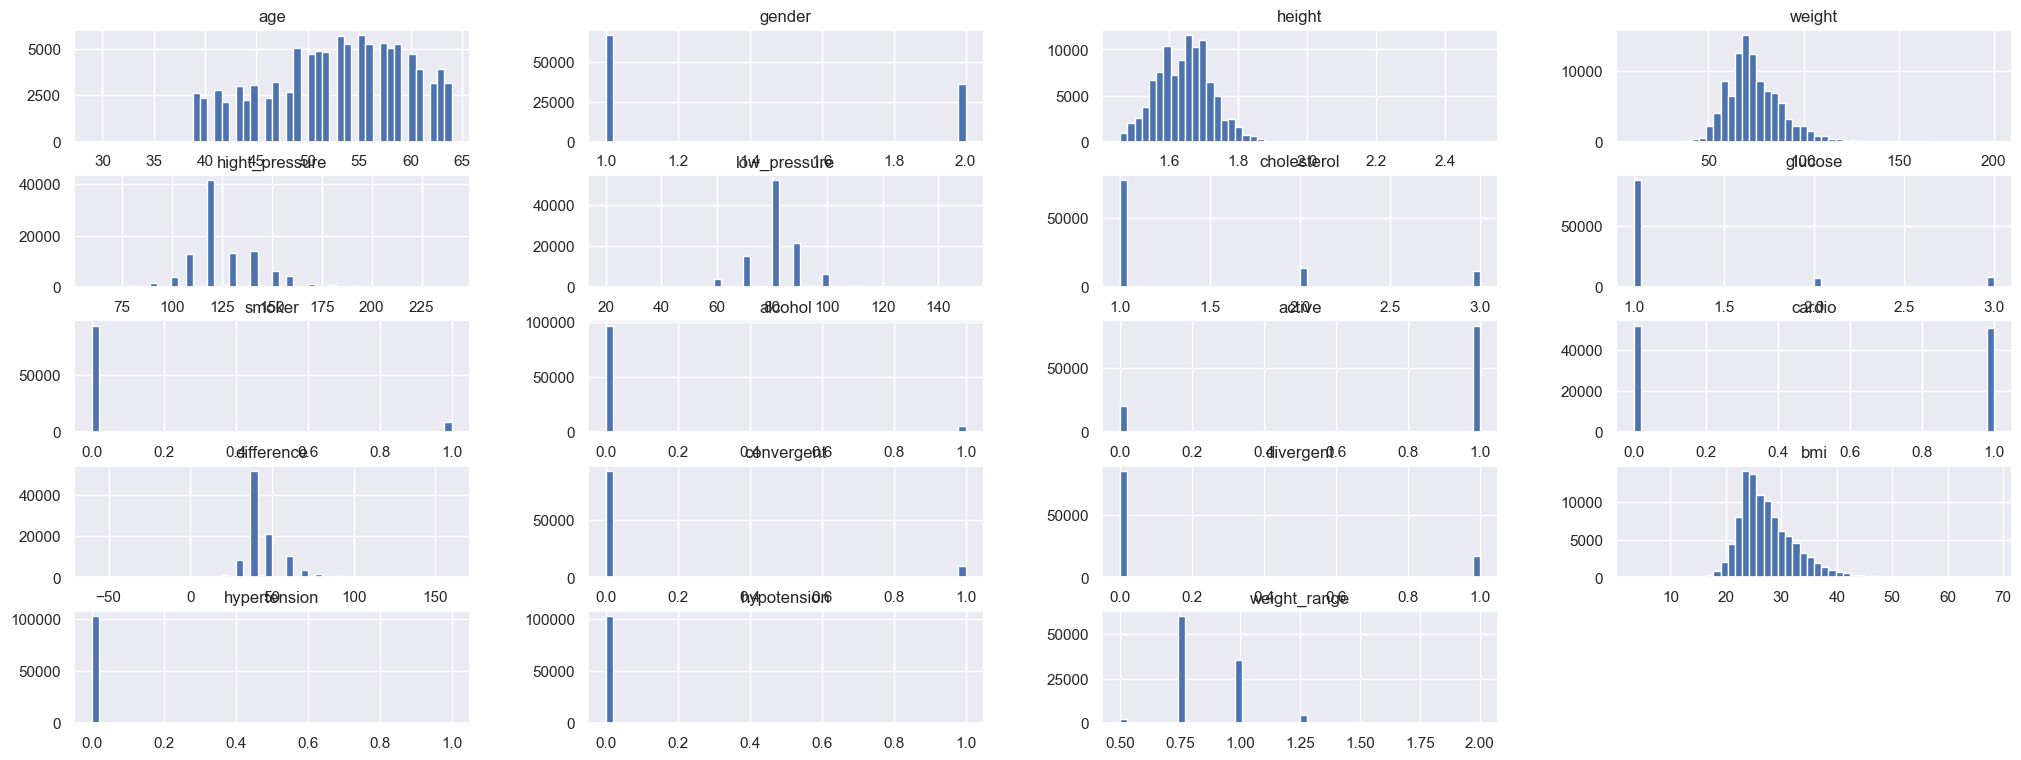

In [72]:
# Distribution from all data
df2.hist(bins=50);

### 5.3 - Bivariate Analysis

#### 5.5 - Hypothesis Answers

##### 5.2.1 - How more active, less diseases
False

NameError: name 'phi_correlation' is not defined

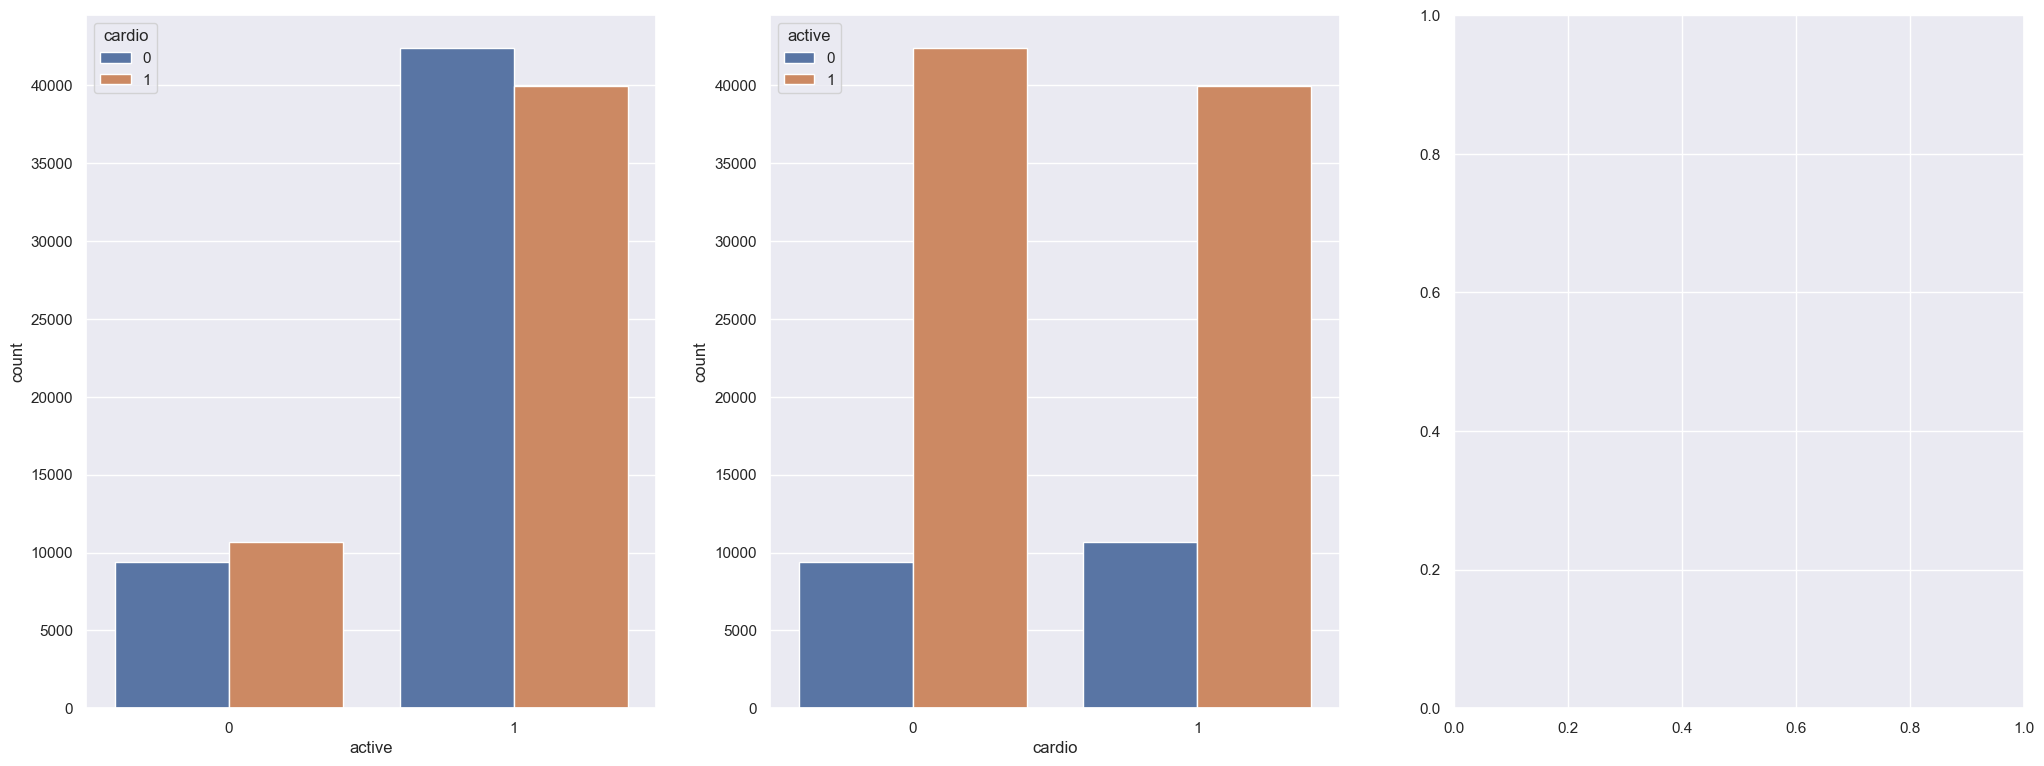

In [76]:
subplot(1,3,1)
sns.countplot(hue='cardio', x='active', data=df1);

subplot(1,3,2)
sns.countplot(x='cardio', hue='active', data=df1);

# phi correlation
subplot(1,3,3)
phi_correlation(df1['cardio'], df1['active']);

In [ ]:
sns.countplot(hue='cardio', x='active', data=df1)

In [ ]:
df1[['active', 'cardio']].groupby('active').mean()

##### 5.2.2 - Cholesterou over level I, more risk
   True

How more cholesterol more diseases, see the number 3 it's more disease==positive than negative, the correlation it's low, but it's possible that feature is't important to model

In [ ]:
plt.subplot(1,3,1)
sns.countplot(df1['cholesterol']);

plt.subplot(1,3,2)
sns.countplot(hue='cardio', x='cholesterol', data=df1);

plt.subplot(1,3,3)
pointb = pointbiserialr(df1['cardio'], df1['cholesterol']).correlation
sns.heatmap(pd.DataFrame({'cardio':pointb}, index=['cholesterol']), annot=True);

##### 5.2.3 - How more clucose, more risk
   True

The correlation it's so low, insignificat to model

In [ ]:
plt.subplot(1,3,1)
sns.countplot(x='glucose', hue='cardio', data=df1)

plt.subplot(1,3,2)
sns.heatmap(df1[['glucose', 'cardio']].corr('pearson'), annot=True);

##### 5.2.4 - How more older, more risk
   True

following the years it's more count and more avarage pear year old, low correlation, but, probly it's important to model

In [ ]:
subplot(1,4,1)
plt.title('Counting')
sns.countplot(x='age', hue='cardio', data=df1);

subplot(1,4,2)
plt.title('Average')
sns.lineplot(data=df1, x='age', y='cardio', estimator='mean');

subplot(1,4,3)
plt.title('Distribution')
sns.distplot(df1['age']);

subplot(1,4,4)
plt.title('Correlation Between Cardio vs Age')
sns.heatmap(df1[['cardio', 'age']].corr('pearson'), annot=True);

##### 5.2.5 - Over 60 year old with Hypertension, more risk
   False

when compare hypertension alone it's more incidence and over 60 alone it's more incidence, but when you group both than it's not more incidence in **averege**.

In [ ]:
aux = df1[['age_range', 'cardio']].groupby('age_range').mean().reset_index()
aux1 = df1[['cardio', 'age_range', 'hypertension']]

plt.subplot(2,2,1)
sns.countplot(hue='cardio', x='hypertension', data=aux1);

plt.subplot(2,2,2)
sns.countplot(x='age', hue='cardio', data=df1);

# Average incidence of diseases by hypertension and over 60 year.
subplot(2,2,3)
aux = df1[['hypertension', 'cardio', 'age_range']].groupby(['hypertension', 'age_range']).mean().reset_index()
sns.barplot(x='age_range', y='cardio', hue='hypertension', data=aux);

subplot(2,2,4)
sns.heatmap(df1[['cardio', 'hypertension', 'age']].corr('pearson'), annot=True);

##### 5.2.6 - 60 year old with Hypotension, more risk
   False

In [ ]:
aux = df1[['hypotension', 'age_range', 'cardio']].groupby(
    ['hypotension', 'age_range']).mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='age_range', y='cardio', hue='hypotension', data=aux);

plt.subplot(1,2,2)
sns.heatmap(df1[['age', 'hypotension', 'cardio']].corr('pearson'), annot=True);

##### 5.2.7 - 60 year old, more risk
   True

The range on 60 year old has a little more incidence of diseases

In [ ]:
aux = df1[['age_range', 'cardio']].groupby('age_range').mean().reset_index()
aux1 = df1[['cardio', 'age_range']]
aux1 = pd.concat([aux1, pd.get_dummies(aux1['age_range'])], axis=1)

plt.subplot(1,2,1)
sns.countplot(x='age_range', hue='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(aux1[['cardio', 'age_60_over']].corr('pearson'), annot=True)

##### 5.2.8 - Divergent AP, more risk
   True - Relevant variable

In [ ]:
aux = df1[['divergent', 'cardio']].groupby('divergent').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='divergent', y='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(df1[['cardio', 'divergent']].corr('pearson'), annot=True)

##### 5.2.9 - Convergent AP, more risk
   False

In [ ]:
plt.subplot(1,2,1)
sns.countplot(x='convergent', hue='cardio',
    data=df1[['cardio', 'convergent']].groupby('convergent').mean().reset_index());

plt.subplot(1,2,2)
sns.heatmap(df1[['cardio', 'convergent']].corr('pearson'), annot=True);

##### 5.2.10 - Hypertension, more risk
   True

Average incidence by Hypertension

In [ ]:
aux = df1[['hypertension', 'cardio']].groupby('hypertension').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='hypertension', y='cardio', data=aux);

plt.subplot(1,3,2)
sns.countplot(x='hypertension', hue='cardio', data=df1);

plt.subplot(1,3,3)
sns.heatmap(df1[['hypertension', 'cardio']].corr('pearson'), annot=True);

In [ ]:
# Hypertension percentual
df1['hypertension'].value_counts()[1] / df1['hypertension'].value_counts()[0] * 100

##### 5.2.11 - Hypotension, more risk
   False

In [ ]:
aux = df1[['hypotension', 'cardio']].groupby('hypotension').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='hypotension', y='cardio', data=aux);

plt.subplot(1,2,2)
sns.heatmap(df1[['hypotension', 'cardio']].corr('pearson'), annot=True);

In [ ]:
df1['hypotension'].value_counts()

##### 5.2.12 - BMI - Obesity, more risk
   True

In [ ]:
aux = df1[['bmi_level', 'cardio']].groupby('bmi_level').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='bmi_level', y='cardio', data=aux, order=['underweight', 'normal', 'overweight', 'obesity']);

plt.subplot(1,2,2)
aux1 = df1.copy()
aux1 = pd.concat([pd.get_dummies(df1['bmi_level']), aux1], axis=1)
sns.heatmap(aux1[['cardio', 'obesity']].corr('pearson'), annot=True);

In [ ]:
sns.countplot(x='bmi_level', data=df1, order=['underweight', 'normal', 'overweight', 'obesity']);

##### 5.2.13 - Gender 2 has more risk
   False

In [ ]:
plt.subplot(1,3,1)
sns.barplot(x='gender', y='cardio', data=df1)

plt.subplot(1,3,2)
sns.heatmap(df1[['gender', 'cardio']].corr('pearson'), annot=True);

plt.subplot(1,3,3)
sns.heatmap([pointbiserialr(df1['gender'], df1['cardio'])], annot=True)

In [ ]:
sns.countplot(x='gender', hue='cardio', data=df1 )

##### 5.2.14 - how more weith more risk
   True

In [ ]:
aux = df1[['weight', 'cardio']].groupby('weight').mean().reset_index()
aux1 = df1[['weight_range', 'cardio']].groupby('weight_range').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0:2])
sns.barplot(x='weight', y='cardio', data=aux);

plt.subplot(grid[1,0])
sns.barplot(x='weight_range', y='cardio', data=aux1);
                 
plt.subplot(grid[1,1])
plt.title('Correlation between CARDIO and WEIGHT')
pointb = pointbiserialr(df1['weight'], df1['cardio']).correlation
sns.heatmap(pd.DataFrame({'weight':pointb}, index=['cardio']), annot=True);

### 5.4 - Multivariate Analysis

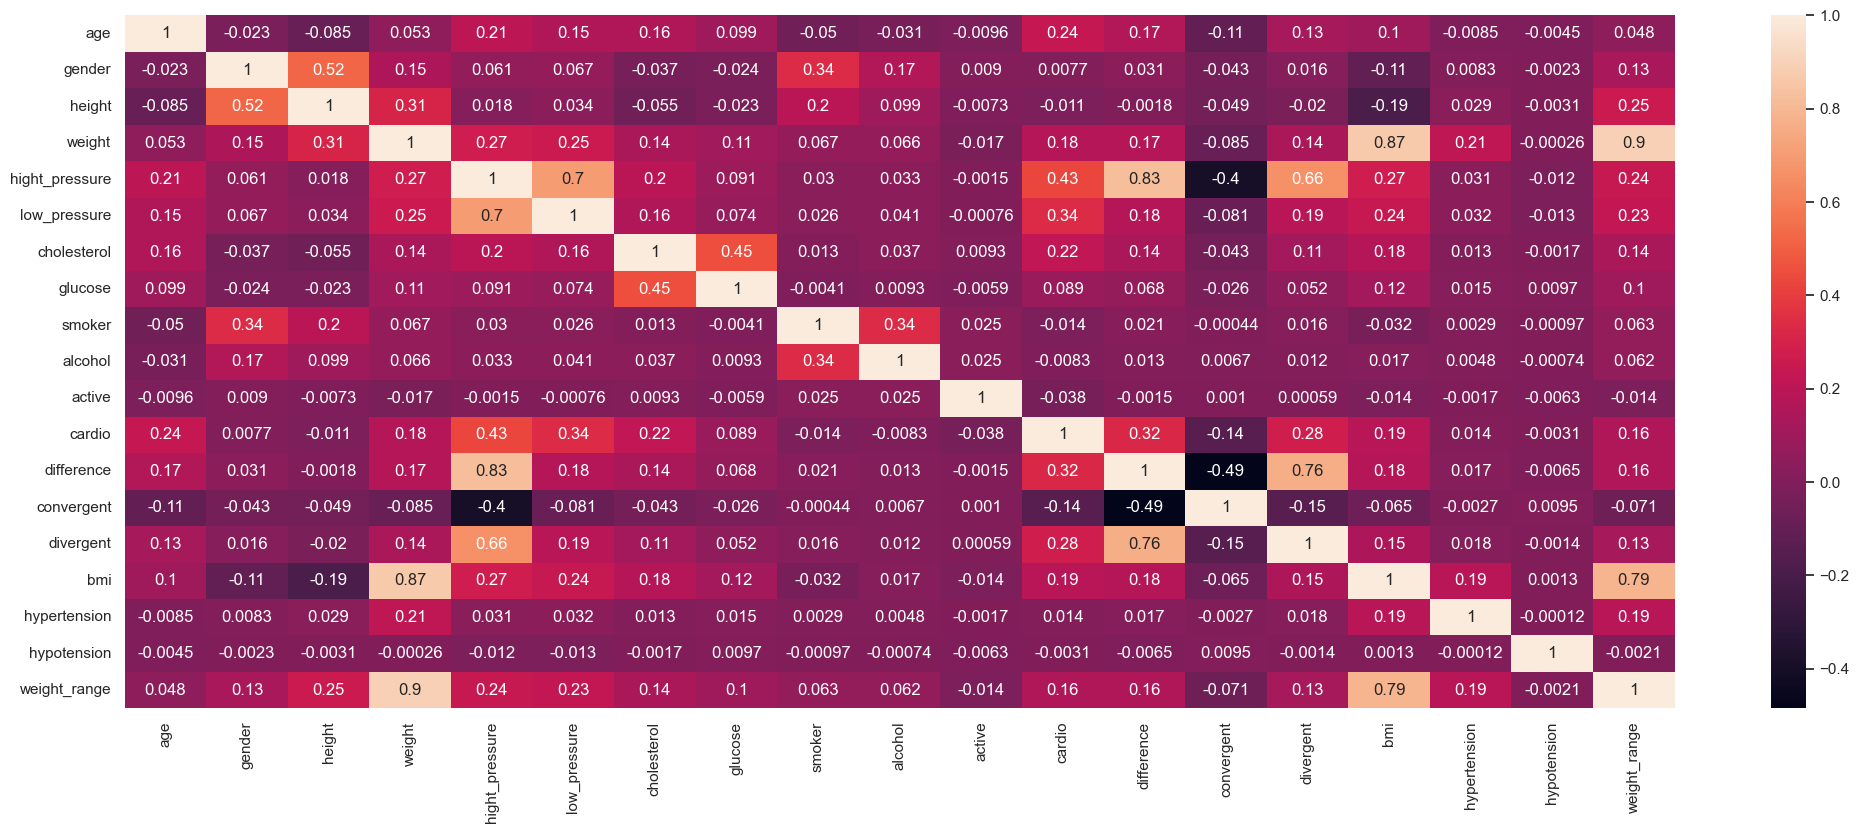

In [77]:
sns.heatmap(df2.corr(), annot=True);

## 6.0 - Data Preparation

### 6.1 - Split - Before Preparation

In [ ]:
X = df1.drop('cardio', axis=1).copy()
y = df1['cardio'].copy()
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
df1 = pd.concat([x_train, y_train], axis=1)
x_test = x_valid
y_test = y_valid

### 6.2 - Normalization

If the data is normal/gaussian distribution
<p>(item - média) / desvio padrão</p>

### 6.3 - Rescaling

If the data it's **NOT** gaussian distribution, gaussian is egual normal distribution

In [ ]:
## The features that it's binary yet, it's not necessary transform
## If has the relevant outlier it's should use to RobustScaler else MinMaxScaler

mms = MinMaxScaler()
rs = RobustScaler()

# age
df1['age'] = mms.fit_transform(df1[['age']].values)
pickle.dump(mms, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/age_scaling.pkl', 'wb'))

# height         
df1['height'] = rs.fit_transform(df1[['height']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/height_scaling.pkl', 'wb'))

# weight
df1['weight'] = rs.fit_transform(df1[['weight']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/weight_scaling.pkl', 'wb'))

# low_pressure   
df1['low_pressure'] = rs.fit_transform(df1[['low_pressure']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/low_pressure_scaling.pkl', 'wb'))

#hight_pressure
df1['hight_pressure'] = rs.fit_transform(df1[['hight_pressure']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/hight_pressure_scaling.pkl', 'wb'))

# difference     
df1['difference'] = rs.fit_transform(df1[['difference']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/difference_scaling.pkl', 'wb'))

# bmi            
df1['bmi'] = rs.fit_transform(df1[['bmi']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/bmi_scaling.pkl', 'wb'))


### 6.4 - Transformation

#### 6.3.1 - Encoding

Transforming category data to numeric

In [ ]:
le = LabelEncoder()

## Label encoding
# age
df1['gender'] = le.fit_transform(df1[['gender']].values)
pickle.dump(le, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/gender_encoder.pkl', 'wb'))

## Ordinal encoding
# age_range 
df1['age_range'] = df1['age_range'].map(
    {'age_0_50':1, 'age_51_59':1, 'age_60_over':3})

# bmi_level
df1['bmi_level'] = df1['bmi_level'].map({
    'underweight':1, 'normal':2, 'overweight':3, 'obesity':4
})

#### 6.3.2 - Nature Transformation

Transforming the data to cycle nature

## 7.0 - Feature Selection

### 7.0 - Split

In [ ]:
## Spliting after rescaling

X = df1.drop('cardio', axis=1).copy()
y = df1['cardio'].copy()
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

### 7.1 - Boruta

In [ ]:
#same pararameter from item 8.0
#x_boruta = x_train.values
#y_boruta = y_train.ravel()
#
#mdl = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)


In [ ]:
# Defining Boruta
#boruta = BorutaPy(mdl, n_estimators='auto', verbose=2, random_state=42).fit(x_boruta, y_boruta)

In [ ]:
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = x_train.iloc[:, cols_selected].copy()

In [ ]:
#x_train = x_train[['bmi', 'weight', 'hight_pressure', 'low_pressure', 'cholesterol', 'age', 'divergent', 'difference']].copy()
#x_valid = x_valid[['bmi', 'weight', 'hight_pressure', 'low_pressure', 'cholesterol', 'age', 'divergent', 'difference']].copy()

## 8.0 - Machine learning

### 8.1 - Baseline

The baseline is the "status quo", between **55%** and **65%** of **PRECISION** Score

### 8.2 - Random Forest

In [ ]:
mdl = RandomForestClassifier(n_estimators=150, random_state=42).fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df1_score_rf = metrics_score(y_valid, y_hat, mdl_name, True, "All Data Features")
df1_score_rf['accuracy_cv'] = mean(n_scores)
df1_score_rf['accuracy_cv_std'] = std(n_scores)
df1_score_rf

### 8.3 - GBDT

<a style="font-size:10px" href="https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/"> Font Coding</a>

In [ ]:
mdl = GradientBoostingClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df1_score_gbdt = metrics_score(y_valid, y_hat, mdl_name, True, "All Data Features")
df1_score_gbdt['accuracy_cv'] = mean(n_scores)
df1_score_gbdt['accuracy_cv_std'] = std(n_scores)
df1_score_gbdt

### 8.4 - Logistic Regression

In [ ]:
mdl = LogisticRegression(random_state=42).fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df1_score_lr = metrics_score(y_valid, y_hat, mdl_name, True, "All Data Features")
df1_score_lr['accuracy_cv'] = mean(n_scores)
df1_score_lr['accuracy_cv_std'] = std(n_scores)
df1_score_lr

### 8.5 - XGBClassifier

<a style="font-size:10px" href="https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/"> Font Coding</a>

In [ ]:
mdl = XGBClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df1_score_xgbc = metrics_score(y_valid, y_hat, mdl_name, True, 'All Data Feature')
df1_score_xgbc['accuracy_cv'] = mean(n_scores)
df1_score_xgbc['accuracy_cv_std'] = std(n_scores)
df1_score_xgbc

### 8.6 - KNClassifier

In [ ]:
mdl = KNeighborsClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
yhat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df1_score_knc = metrics_score(y_valid, y_hat, mdl_name, True, 'All Data Feature')
df1_score_knc['accuracy_cv'] = mean(n_scores)
df1_score_knc['accuracy_cv_std'] = std(n_scores)
df1_score_knc

### 8.7 - LGBMClassifier

In [ ]:
mdl = LGBMClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df1_score_lgbmc = metrics_score(y_valid, y_hat, mdl_name, True, 'All Data Features')
df1_score_lgbmc['accuracy_cv'] = mean(n_scores)
df1_score_lgbmc['accuracy_cv_std'] = std(n_scores)
df1_score_lgbmc

### 8.8 - Hyperparameters

In [ ]:
parameters = {'learning_rate':[0.01, 0.08], 
    'n_estimators':[100, 150],
    'subsample':[0.08, 0.1, 0.2, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'min_samples_split':[0.3, 0.6, 0.8, 2, 3, 4],
    'min_samples_leaf':[1, 2, 3, 4], 
    'max_depth':[3, 5, 10, 15, 20, 25]}

In [ ]:
MAX_EVALS = 50
df1_hyper = pd.DataFrame(columns=['Mean_accuracy', 'Std_accuracy', 'Parameters'])

for i in range(MAX_EVALS):
    print(f'evals: {i}')
    
    hp = {k:sp(v, 1)[0] for k, v in parameters.items()}
    print(f'Hyperparameters: {hp}')
    mdl = GradientBoostingClassifier(
        learning_rate=hp['learning_rate'], n_estimators=hp['n_estimators'],
        subsample=hp['subsample'], min_samples_split=hp['min_samples_split'],
        min_samples_leaf=hp['min_samples_leaf'], max_depth=hp['max_depth'],
        loss='deviance', random_state=42
        ).fit(x_train, y_train)
    print('trained...')
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print('crossvalidation finished')
    
    df1_cv = pd.DataFrame([[mean(n_scores), std(n_scores), hp]], 
                        columns=['Mean_accuracy', 'Std_accuracy', 'Parameters'])
    
    print(df1_cv)
    df1_hyper = pd.concat([df1_hyper, df1_cv], axis=0)
    
df1_hyper

### 8.9 - Final Model

In [ ]:
final_model = GradientBoostingClassifier().fit(x_train, y_train)
#pickle.dump(final_model, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/model/model_trained.pkl', 'wb'))

## 9.0 - Metrics

### 9.1 - Validation

In [ ]:
## all scoring sbs == spliting before scaling
df1_all_scores_sbs = pd.concat([df1_score_rf, df1_score_gbdt, df1_score_lr, df1_score_xgbc, df1_score_knc, df1_score_lgbmc], axis=0)
df1_all_scores_sbs

In [ ]:
with open('score_cycle_02.pkl', 'rb') as file:
    df1_score_pic = pickle.load(file)
    
df1_all_scores_concat = pd.concat([df1_score_pic, df1_all_scores_sbs], axis=0)
df1_all_scores_concat

### 9.2 - Cross Validation

In [ ]:
## all scoring split before scaling

df1_all_scores_cv = pd.concat([df1_score_rf, df1_score_gbdt, df1_score_lr, df1_score_xgbc, 
                              df1_score_knc, df1_score_lgbmc], axis=0)
# rename column 
df1_all_scores_cv.columns = ['mdl_name', 'accuracy', 'precision', 'recall', 'split_before_scaling',
                            'date', 'obs', 'accuracy_cv', 'accuracy_cv_std']

# reordenation from columns
df1_all_scores_cv[['mdl_name', 'accuracy', 'accuracy_cv', 'accuracy_cv_std', 'precision', 
                 'recall', 'split_before_scaling', 'date', 'obs']]

**Gradient Boosting it's better**

In [ ]:
## Exporting result from cross validation
#with open('score_cycle_02_cv.pkl', 'wb') as file:
#    pickle.dump(df1_all_scores_cv, file)

### 9.3 - Test Data

If the data is normal/gaussian distribution
<p>(item - média) / desvio padrão</p>

#### 9.2.1 - Rescaling

If the data it's **NOT** gaussian distribution, gaussian is egual normal distribution

In [ ]:
## The features that it's binary yet, it's not necessary transform
## If has the relevant outlier it's should use to RobustScaler else MinMaxScaler

mms = MinMaxScaler()
rs = RobustScaler()

# age
x_test['age'] = mms.fit_transform(x_test[['age']].values)

# height         
x_test['height'] = rs.fit_transform(x_test[['height']].values)

# weight
x_test['weight'] = rs.fit_transform(x_test[['weight']].values)

# low_pressure   
x_test['low_pressure'] = rs.fit_transform(x_test[['low_pressure']].values)

#hight_pressure
x_test['hight_pressure'] = rs.fit_transform(x_test[['hight_pressure']].values)

# difference     
x_test['difference'] = rs.fit_transform(x_test[['difference']].values)

# bmi            
x_test['bmi'] = rs.fit_transform(x_test[['bmi']].values)

#### 9.2.2 - Transformation

#### 9.2.3 - Encoding

Transforming category data to numeric

In [ ]:
le = LabelEncoder()

## Label encoding
# age
x_test['gender'] = le.fit_transform(x_test[['gender']].values)


## Ordinal encoding
# age_range 
x_test['age_range'] = x_test['age_range'].map(
    {'age_0_50':1, 'age_51_59':1, 'age_60_over':3})

# bmi_level
x_test['bmi_level'] = x_test['bmi_level'].map({
    'underweight':1, 'normal':2, 'overweight':3, 'obesity':4
})

#### 9.2.4 - Modeling and Metrics

In [ ]:
mdl = GradientBoostingClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_test)

df1_score_gbdt_test = metrics_score(y_test, y_hat, mdl_name, True, "All Data Features")
df1_score_gbdt_test

### 9.4 - Business Performance

In [ ]:
cost_status_quo = 1000                         ## cost of each diagnostic with operators and machines
percentual_status_quo = (0.55+0.65)/2
revenue_status_quo = int((percentual_status_quo - 0.50)/0.05) * 500
result_status_quo = revenue_status_quo - cost_status_quo

cost_future = 0
standard = 0.006706
percentual_future = (0.752+0.765)/2
revenue_future = int((percentual_future - 0.50)/0.05) * 500  
result_model_future = revenue_future - cost_future   

In [ ]:
pd.concat([pd.Series(result_status_quo), pd.Series(result_model_future)]).reset_index().T.plot(kind='bar');

## 10.0 - Deploy

### 10.1 - Class

In [ ]:
import pandas as pd
import numpy as np
import json
import pickle

# this file will be a handler "API"
class Cardio_Catch_Diseases(object):
    def __init__(self):
        self.home_path              = '/home/python/Documents/Projects/pa001_cardio_catch_diseases/'
        self.age_scaling            = pickle.load(open(self.home_path + 'parameters/age_scaling.pkl', 'rb'))
        self.bmi_scaling            = pickle.load(open(self.home_path + 'parameters/bmi_scaling.pkl', 'rb'))
        self.difference_scaling     = pickle.load(open(self.home_path + 'parameters/difference_scaling.pkl', 'rb'))
        self.height_scaling         = pickle.load(open(self.home_path + 'parameters/height_scaling.pkl', 'rb'))
        self.hight_pressure_scaling = pickle.load(open(self.home_path + 'parameters/hight_pressure_scaling.pkl', 'rb'))
        self.low_pressure_scaling   = pickle.load(open(self.home_path + 'parameters/low_pressure_scaling.pkl', 'rb'))
        self.weight_scaling         = pickle.load(open(self.home_path + 'parameters/weight_scaling.pkl', 'rb'))
        self.gender_encoder         = pickle.load(open(self.home_path + 'parameters/gender_encoder.pkl', 'rb'))


    
    def data_cleaning(self, df1):
        '''df1: is the input data from user on website'''


        # height - change centimeters to meters
        df1['height'] = (df1['height'] / 100)

        return df1

    def feature_engineering(self, df1):
        '''Get the dataframe from data cleaning and create a new features'''


        # feature engineering
        df1['difference'] = df1['hight_pressure'] - df1['low_pressure']
        df1['convergent'] = df1['difference'].apply(lambda x: 1 if x <= 30 else 0)
        df1['divergent'] = df1['difference'].apply(lambda x: 1 if x >= 60 else 0)
        df1['bmi'] = (df1['weight']/(df1['height'] * df1['height']))
        df1['bmi_level'] = df1['bmi'].apply(lambda x: 
                                                      'underweight' if x <= 18.5 else
                                                      'normal'      if x >  18.5 and x <= 24.9 else
                                                      'overweight'  if x >= 25.0 and x <= 29.9 else
                                                      'obesity')
        df1['hypertension'] = df1.apply(lambda x: 1 if x[4] >=140 and x[5] >= 90 else 0, axis=1)
        df1['hypotension'] = df1.apply(lambda x: 1 if x[4] <=90 and x[5] <= 60 else 0, axis=1)
        df1['age_range'] = df1['age'].apply(lambda x: 'age_0_50'    if x <= 50 
                                                           else 'age_51_59'   if x >= 51 and x <= 59 
                                                           else 'age_60_over' if x >= 60 
                                                           else x)

        df1['weight_range'] = df1['weight'].apply(
            lambda x:   0.50 if x <= 50  else
                        0.75 if x >= 51  and x <= 75 else
                        1.00 if x >= 76  and x <= 100 else
                        1.25 if x >= 101 and x <= 125 else
                        1.50 if x >= 126 and x <= 150 else
                        1.75 if x >= 151 and x <= 175 else 2.00)

        # Data Filtering rows, values or columns
        df1 = df1.drop('id', axis=1)

        return df1


    def data_rescaling(self, df1):
        '''
        Rescaling data
        Return: json file with x_test data to input the prediction
        '''


        # Transforming data to will be in correct data scaler to input at model
        df1['age']            = self.age_scaling.transform(df1[['age']].values)
        df1['height']         = self.height_scaling.transform(df1[['height']].values)
        df1['weight']         = self.weight_scaling.transform(df1[['weight']].values)
        df1['low_pressure']   = self.low_pressure_scaling.transform(df1[['low_pressure']].values)
        df1['hight_pressure'] = self.hight_pressure_scaling.transform(df1[['hight_pressure']].values)
        df1['difference']     = self.difference_scaling.transform(df1[['difference']].values)
        df1['bmi']            = self.bmi_scaling.transform(df1[['bmi']].values)
        df1['gender']         = self.gender_encoder.transform(df1[['gender']].values)
        df1['age_range']      = df1['age_range'].map(
            {'age_0_50':1, 'age_51_59':1, 'age_60_over':3})
        df1['bmi_level']      = df1['bmi_level'].map(
            {'underweight':1, 'normal':2, 'overweight':3, 'obesity':4})

        # Deleting target
        x_test = df1.drop('cardio', axis=1).copy()
        #data_json = json.dumps(x_test.to_dict(orient='records')) # converto to json

        return x_test

### 10.2 - Input Simulation

In [ ]:
import pandas as pd

def input_simulation():
    # inputs from user
    
    age = input('age: ')
    gender = int(input('gender: '))
    height = int(input('height: '))
    weight = float(input('weight: '))
    ap_hi = int(input('hight_pressure: '))
    ap_lo = int(input('low_pressure: '))
    cholesterol = int(input('cholesterol (1,2 or 3): '))
    gluc = int(input('glucose (1,2 or 3): '))
    smoke = int(input('smoker: '))
    alco = int(input('alcohol: '))
    active = input('active: ')

    # replacing columns names
    new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
               'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']

    # getting data and converting to dataframe
    df1_inputed = [[1, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, 0,]]
    df1 = pd.DataFrame(df1_inputed, columns=new_col)

    # datatypes transformations
    df1['age'] = df1['age'].astype('int64')
    df1['gender'] = df1['gender'].astype('int64')
    df1['height'] = df1['height'].astype('int64')
    df1['weight'] = df1['weight'].astype('float64')
    df1['hight_pressure'] = df1['hight_pressure'].astype('int64') 
    df1['low_pressure'] = df1['low_pressure'].astype('int64') 
    df1['cholesterol'] = df1['cholesterol'].astype('int64')
    df1['glucose'] = df1['glucose'].astype('int64')
    df1['smoker'] = df1['smoker'].astype('int64') 
    df1['alcohol'] = df1['alcohol'].astype('int64')
    df1['active'] = df1['active'].astype('int64')
    df1['cardio'] = df1['cardio'].astype('int64')

    return json.dumps(df1.to_dict(orient='records'))

### 10.2 - API / Handler

In [ ]:
import pickle
import pandas as pd
import numpy as np
from flask import Flask, request, Response
from ccd.ccd import Cardio_Catch_Diseases
import json

# loading model trained from pickle file
with open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/model/model_trained.pkl', 'rb') as file:
    model = pickle.load(file)

# initialized API
app = Flask(__name__)

@app.route('/ccd/predict', methods=['POST'])
def ccd_predict():
    '''
    ccd: Cardio Catch Diseases
    This function it will be create the API request, where the user will be input the user data that 
    will used to data_cleaning(), data_engineering(), data_scaler() 
    this functions will be return the dataframe 'x_est', that will be used to predict
    Return: Prediction "array"
    '''
    
    test_json = request.get_json()
        
    if test_json:
        if isinstance(test_json, dict): # Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate CCD class
        pipeline = Cardio_Catch_Diseases()
        # cleaning data
        test_raw_cleaned = pipeline.data_cleaning(test_raw)
        # creating derivates to new features
        test_raw_features = pipeline.feature_engineering(test_raw_cleaned)        
        
        # preparing data to model
        test_raw_selected = pipeline.data_rescaling(test_raw_features)
        
        y_hat = model.predict(test_raw_selected)
        test_raw['prediction'] = y_hat.copy()
        return test_raw.to_json(orient='records')
    
    else:
        return Response( "{}", status=200, mimetype='application/json')

    
if __name__=='__main__':
    app.run('0.0.0.0')

### 10.2 - API Request Tester

In [ ]:
import requests

# Input data user
data = input_simulation()

# API request
url = "https://ccd-model.herokuapp.com/ccd/predict"
header = {'Content-type': 'application/json'}

response_ccd = requests.post(url, data=data, headers=header)
print(f'Status Code: {response_ccd.status_code}')

df1_response = pd.DataFrame(response_ccd.json(), columns=response_ccd.json()[0].keys())

# Loading json to Dataframe
df1_new = pd.DataFrame(json.loads(data))

# converting to back the original datatype
df1_new['age'] = df1_new['age'] * 365

# getting prediction
df1_new['cardio'] = df1_response['cardio'].copy()

# getting current time in seconds since the Epoch.
# convert to normal date use time.ctime(time.time())
df1_new['id'] = time.time()

# Insert into database
insert_database_values(df1_new)

df1_response

## 11.0 - Dashboard - PowerBI

In [ ]:
# Connecting sqlite database
import pandas as pd
from sqlalchemy import create_engine

new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
           'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']

engine = create_engine('sqlite:///Y:\\pa001_cardio_catch_diseases\\ccd.db', echo=False)
df1 = engine.execute('SELECT * FROM patients').fetchall()
df1 = pd.DataFrame(df1, columns=new_col)

# Data Preparation/transformation

